# Neural networks

###### COMP4670/8600 - Statistical Machine Learning - Tutorial



Setting up the environment

In this lab, we will train a neural network as a classifer.

## Textbook Questions
These questions are hand picked to both be of reasonable difficulty and demonstrate what you are expected to be able to solve. The questions are labelled in Bishop as either $\star$, $\star\star$, or $\star\star\star$ to rate its difficulty.

- **Question 5.1**: First derive the relationship between $\tanh(\alpha)$ and $\sigma(\alpha)$, then use Eq. 5.4 in Bishop to compare those two neural networks. The key point is having a clear definition of the notations you will use.

- **Question 5.2**: Please figure out which parts of Gaussian distribution have parameters when taking the logarithm.

- **Question 5.6**: Students should always know where the activation comes from and express the derivative of logistic sigmoid function in terms of the sigmoid function itself.

- **Question 5.15**: Use the symmetry between backpropagation and forward propagation.

- **Question 5.25**: Challenging but important question. Show you in which case gradient descent really work. First represent the current weight with its previous value and then use mathematical induction to prove Eq. 5.197.

- **Question 5.27**: Follow what Section 5.5.5 did.

- **Question 5.29**: Students should understand how to take the derivative of Gaussian distribution.

- **Question 5.40**: Maping binary classfication domain to multiclass domain is a very practical demand.

### Assumed knowledge
- Neural networks (lectures)
- Classifiers (lab)

### After this lab, you should be comfortable with:
- Implementing a neural network and a simple optimizer
- Calculating back-propogation formulas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
%matplotlib inline

## Load the data

We will be working with a similar dataset to the one used in the Classification lab.
This is a census-income dataset, which shows income levels for people in the 1994 US Census. We will predict whether a person has $\leq \$50000$ or $> \$50000$ income per year.

Unlike in the Classification lab, this data is not linearly separable. That is, the linear classification techniques you learnt about in previous weeks are not effective on this data.

The data is included with this notebook as `05-dataset.tsv`. Load the data into a NumPy array called `data` using numpy genfromtxt function.
The column names are given in the variable `columns` below.

In [2]:
columns = ['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']

In [3]:
data = np.genfromtxt("05-dataset.tsv")
data.shape

(32561, 8)

In this tutorial we will implement a neural network using only numpy functions.

## Building blocks for a neural network

Neural network libraries like PyTorch and TensorFlow seal different functionalities into different classes.

First, implement the fully connected layer which does $\mathbf{y} = X\mathbf{w} + \mathbf{b}$.
It is also called Linear layer in PyTorch or Dense layer in TensorFlow.

In [4]:
# Solution

class FullyConnectedLayer():
    """
    This is a class skeleton provided.
    It should perform y = Xw + b and its correspongding gradient.
    If you never defined any classes in python before, you probably want to read other tutorials.
    """
    def __init__(self, in_features, out_features):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        What each represents will be explained in the next few functions.
        """
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.zeros((in_features, out_features))
        self.bias = np.zeros((out_features, 1))
        self.g_weight = np.zeros((in_features, out_features))
        self.g_bias = np.zeros((out_features, 1))
        self.input = None

    def init_weights(self):
        """
        Currently, the weight and bias of this layer is initilized to zero, which is terrible.
        You want to re-initilize the weight with standard normal distribution 
        and the bias with uniform distribution defined on range 0 to 1.
        Or you can try different initilization methods.
        After you finish, comment out raise NotImplementedError.
        No return value is needed.
        """
        
        self.weight = np.random.randn(self.in_features, self.out_features)
        self.bias = np.random.rand(self.out_features, 1)

    def forward_pass(self, X):
        """
        Take the output of last layer as X and return the result.
        Don't forget to save the input X to self.input. You will need the input for gradient calculation.
        After you finish, comment out raise NotImplementedError.
        If you are new to python/numpy, you probably want to figure out what is broadcasting 
        (see http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting).
        """

        
        self.input = X
        
        out = np.dot(X, self.weight) + self.bias.T
      
        return out
        

    def backward_pass(self, g_next_layer):
        """
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        You need to calculate 3 things.
        First, the gradient with respect to bias, self.g_bias.
        Second, the gradient with respect to weights, self.g_weight.
        Third, the gradient with respect to last layer (the layer formed by the current weight and bias), g_last_layer.
        Save the gradient with respect to bias and the gradient with respect to weight.
        Return the gradient with respect to last layer.
        """

        self.g_weight = np.dot(self.input.T, g_next_layer)
        self.g_bias = np.sum(g_next_layer, axis=0, keepdims=True)

        g_last_layer = np.dot(g_next_layer, self.weight.T)

        return g_last_layer

    def update(self, learning_rate):
        """
        Update the weight and bias use the gradient that you just calculated.
        No return is needed.
        """
        
        self.weight -= learning_rate*self.g_weight
        self.bias -= learning_rate*self.g_bias.T


### Question 1:

Why is initialising weights and biases to zero terrible?

### Solution

Intialising every value in the weights and biases to the same value is terrible, as then the gradient update is the same for all of them, so the weights and biases will remain a uniform value.

Now let's implement sigmoid function and sigmoid layer.

In [5]:
# Solution

def sigmoid(X):
    """
    Make sure that you function works with X being matrix.
    Use functions in numpy instead of functions in math.
    """
    return 1/(1 + np.exp(-X))

In [6]:
# Solution

class Sigmoid():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None
        self.ctx = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        
        self.input = X
        self.ctx = sigmoid(X)

        return self.ctx

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        g_last_layer = self.ctx * (1 - self.ctx) * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

### Question 2:

Why do we need the activation function to be non-linear?

### Solution
Writing out the math operation executed by two consecutive fully connected layers with the identity transformation we get that:

$$(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b_2} = \mathbf{x}\mathbf{W}_1\mathbf{W}_2 + \mathbf{b}_1\mathbf{W}_2 + \mathbf{b}_2$$

Denote $\mathbf{W}_3 = \mathbf{W}_1\mathbf{W}_2$ and $\mathbf{b}_3 = \mathbf{b}_1\mathbf{W}_2 + \mathbf{b}_2$

Then we get 

$$(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2 = \mathbf{x}\mathbf{W}_3 + \mathbf{b}_3$$

so our two layer network is actually equivalent to some other network with only one fully connected layer.

Likewise if the activation function is a general linear transformation, we could represent it as another matrix $\mathbf{W}_4$ which we could factor into $\mathbf{W}_2$ and get the same result.

However we could not have factorised our two layer network into an equivalent one layer network if there was a non-linear activation function.

Now let's implement binary cross entropy loss and yes, this is the same loss that you used in logistic regression.
Binary cross entropy loss can only deal with two classes. For more than two classes you need softmax function and cross entropy, but let's not worry about that.

In [7]:
# Solution

class BinaryCrossEntropyLoss():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input_y = None
        self.input_t = None
        self.input_N = None


    def forward_pass(self, y, t):
        """
        y: batch_size * 1  0 <= y <= 1, the predictions
        t: batch_size * 1 , the targets
        (make sure y and t have the same shape. (N,) and (N,1) are different!)
        
        Save the input y, t and batch size N and calculate the loss.
        Return the mean of the loss (a scalar).
        """
        
        if len(t.shape) == 1:
            t = t[:, None]

        self.input_y = y
        self.input_t = t
        self.input_N = X.shape[0]

        loss = -(t*np.log(y) + (1-t)*np.log(1 - y))

        return np.mean(loss)
    
    def backward_pass(self, g_next_layer = 1):
        """
        Nomrally, loss layer is the last layer in a neural network. Thus, we set the g_next_layer to 1.
        Calculate the loss of the input y.
        """
        g_last_layer = - (self.input_t/self.input_y - (1 - self.input_t)/(1 - self.input_y))/self.input_N * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass
    

Let's implement a neural network with one hidden layer to solve this classification problem. 

### Question 3
How many input units would there be? How many output units?

### Solution

7 input units, 1 output unit.

## Put them together

Put the bulding block together to form a neural network.

In [8]:
# Solution

class Network():
    def __init__(self):
        """
        Since our simple nerual network acts sequentially, 
        we can put all layers in a list for convenient traversal
        Initialize all layers that you need (two fully connected layers, two sigmoid layers).
        Append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers. Choose a sensible hidden layer size.
        """
        self.sequential = []
        
        fc1 = FullyConnectedLayer(7, 16)
        fc1.init_weights()
        self.sequential.append(fc1)

        sigmoid1 = Sigmoid()
        self.sequential.append(sigmoid1)

        fc2 = FullyConnectedLayer(16, 1)
        fc2.init_weights()
        self.sequential.append(fc2)

        sigmoid2 = Sigmoid()
        self.sequential.append(sigmoid2)
        
        
    def forward_pass(self, X):

        for l in self.sequential:

            X = l.forward_pass(X)

        return X

    def backward_pass(self, grad):
        
        for l in reversed(self.sequential):

            grad = l.backward_pass(grad)
            

    def update(self, learning_rate):

        for l in self.sequential:

            l.update(learning_rate)

In [9]:
np.random.seed(1)
net = Network()
bce = BinaryCrossEntropyLoss()

You have already set up a neural network.
In the backward_pass function of each layer, you calculated the gradient of the input and the gradient of the weight.
Now, get a pen and a paper and try to replace g_next_layer with the backward_pass function of the next layer, all the way back to binary cross entropy loss. Don't change any code, just write it down.

Compare the results with the text book.
I hope you can see how this layer structure naturally implements the chain rule. 

## Training the neural network

Split your data in half randomly, into a test set and a training set. Train the neural network on your training set. You may want to google train_test_split and accuracy_score of sklearn.
If you get any memory error, make sure that all vectors in you calculate have shape (D, 1). (D, 1) and (D,) are different.
Don't forget to normalize each feature to get mean 0 and variance 1.

In [10]:
""" Generate train and testing set """

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
data = np.genfromtxt("05-dataset.tsv")

y = data[:, 0]
X = data[:, 1:]

X_mean = X.mean(axis = 0)

X -= X_mean
X /= np.var(X, axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

training_epoch = 1000

train_acc_list = np.zeros(training_epoch)
train_loss_list = np.zeros(training_epoch)
test_acc_list = np.zeros(training_epoch)
test_loss_list = np.zeros(training_epoch)

training_epoch = 1000

train_acc_list = np.zeros(training_epoch)
train_loss_list = np.zeros(training_epoch)
test_acc_list = np.zeros(training_epoch)
test_loss_list = np.zeros(training_epoch)

In [11]:
for i in range(training_epoch):
    """
    This is the main training loop.
    You need to first run a forward pass, get the predicted probability, 
    put it into the loss function, calculate the loss and do a back pass.
    Then update the network.
    Calculate the test loss and the current accuracy on both the train and test sets.
    Save these to a list for plotting later.
    Experiment to find a good learning rate.
    """

    p = net.forward_pass(X_train)
    
    predict = (p > 0.5)

    train_acc = accuracy_score(y_train, predict)
    
    train_loss = bce.forward_pass(p, y_train)
    
    train_acc_list[i] = train_acc
    train_loss_list[i] = train_loss

    grad = bce.backward_pass()
    
    net.backward_pass(grad)
    
    net.update(0.1)
    
    p = net.forward_pass(X_test)
    
    predict = (p > 0.5)

    test_acc = accuracy_score(y_test, predict)
    test_loss = bce.forward_pass(p, y_test)
    
    test_acc_list[i] = test_acc
    test_loss_list[i] = test_loss

    print("iteration %d: train_acc %f, train_loss %f, test_acc %f, test_loss %f" %(i+1, train_acc, train_loss, test_acc, test_loss))

iteration 1: train_acc 0.259705, train_loss 0.824344, test_acc 0.514649, test_loss 0.789516
iteration 2: train_acc 0.512162, train_loss 0.790993, test_acc 0.655427, test_loss 0.760039
iteration 3: train_acc 0.652826, train_loss 0.762136, test_acc 0.659849, test_loss 0.734452
iteration 4: train_acc 0.651044, train_loss 0.737104, test_acc 0.652540, test_loss 0.712171
iteration 5: train_acc 0.642568, train_loss 0.715318, test_acc 0.650144, test_loss 0.692695
iteration 6: train_acc 0.639988, train_loss 0.696286, test_acc 0.650021, test_loss 0.675601
iteration 7: train_acc 0.639803, train_loss 0.679592, test_acc 0.650021, test_loss 0.660532
iteration 8: train_acc 0.639926, train_loss 0.664882, test_acc 0.650021, test_loss 0.647187
iteration 9: train_acc 0.639926, train_loss 0.651861, test_acc 0.650021, test_loss 0.635314
iteration 10: train_acc 0.639865, train_loss 0.640280, test_acc 0.649960, test_loss 0.624701
iteration 11: train_acc 0.640049, train_loss 0.629932, test_acc 0.649960, test_

Plots of training accuracy curve against testing accuracy curve, and training loss curve against testing loss curve.

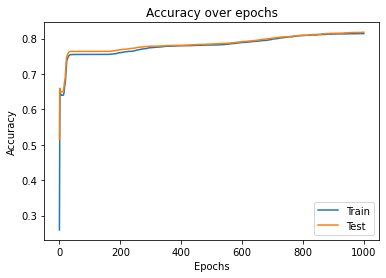

In [12]:
plt.title("Accuracy over epochs")
plt.plot(train_acc_list, label="Train")
plt.plot(test_acc_list, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

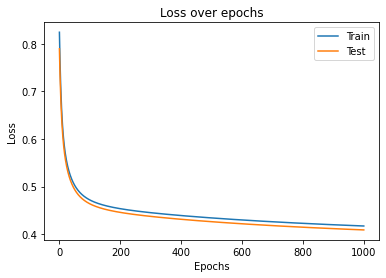

In [13]:
plt.title("Loss over epochs")
plt.plot(train_loss_list, label="Train")
plt.plot(test_loss_list, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Here is an super cool website:https://playground.tensorflow.org/.
Have fun in there.

# AutoGrad in Pytorch

### Question: 



#### 1. What is Autodiff? 

Autograd is a reverse automatic differentiation system. Conceptually, autograd records a graph recording all of the operations that created the data as you execute operations, giving you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors.

**Easy-to-understand Analogy:**

Imagine you are a baker, and you have a recipe for a cake that involves several ingredients, such as flour, sugar, eggs, and butter. You want to know how much each ingredient contributes to the final taste of the cake, so you decide to experiment by changing the amount of each ingredient and tasting the cake afterwards.

To keep track of the changes you make to the recipe and their effect on the taste of the cake, you write down each step and its corresponding result in a notebook. For example, you might write "added 100g of sugar, cake tasted sweeter" or "reduced flour by 50g, cake tasted less dense".

Autograd works in a similar way, by keeping track of the operations performed on tensors (which are like the ingredients in our recipe) and their corresponding gradients (which are like the taste of the cake). When a tensor is created with requires_grad=True, autograd records the operations performed on that tensor and builds a computational graph that allows it to compute the gradients of the output with respect to the input tensors.

**For example, suppose we have the following code:**

In [ ]:
import torch

x = torch.tensor([3.0], requires_grad=True)
y = x**2 + 2*x + 1
y.backward()
print(x.grad)

In this code, we create a tensor x with the value of 3.0 and set requires_grad=True to enable autograd to compute the gradients. We define y as x**2 + 2*x + 1, which is a function of x. We then call y.backward() to compute the gradients of y with respect to x, which are stored in x.grad. Finally, we print the value of x.grad, which should be equal to 8.0.

In this example, autograd records the operations performed on x, which are squaring (x**2), multiplying by 2 (2*x), and adding 1 (+1). It then computes the gradients of y with respect to x using the chain rule, which involves multiplying the gradients of each operation in reverse order. The resulting gradient of y with respect to x is 2x + 2, which evaluates to 8 when x=3.


#### 2. Which is more efficient, auto differentiation or symbolic differentiation? And why?

Autodiff is more efficient. 
In training a model, we want to minimize the loss. In the idealized case
of a perfect model, that means adjusting its learning weights - that is,
the adjustable parameters of the function - such that loss is zero for
all inputs. In the real world, it means an iterative process of nudging
the learning weights until we see that we get a tolerable loss for a
wide variety of inputs.

How do we decide how far and in which direction to nudge the weights? We
want to *minimize* the loss, which means making its first derivative
with respect to the input equal to 0:
$\frac{\partial L}{\partial x} = 0$.

Recall, though, that the loss is not *directly* derived from the input,
but a function of the model’s output (which is a function of the input
directly), $\frac{\partial L}{\partial x}$ =
$\frac{\partial {L({\vec y})}}{\partial x}$. By the chain rule of
differential calculus, we have
$\frac{\partial {L({\vec y})}}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial M(x)}{\partial x}$.

$\frac{\partial M(x)}{\partial x}$ is where things get complex.
The partial derivatives of the model’s outputs with respect to its
inputs, if we were to expand the expression using the chain rule again,
would involve many local partial derivatives over every multiplied
learning weight, every activation function, and every other mathematical
transformation in the model. The full expression for each such partial
derivative is the sum of the products of the local gradient of *every
possible path* through the computation graph that ends with the variable
whose gradient we are trying to measure.

In particular, the gradients over the learning weights are of interest
to us - they tell us *what direction to change each weight* to get the
loss function closer to zero.

Since the number of such local derivatives (each corresponding to a
separate path through the model’s computation graph) will tend to go up
exponentially with the depth of a neural network, so does the complexity
in computing them. This is where autograd comes in: It tracks the
history of every computation. Every computed tensor in your PyTorch
model carries a history of its input tensors and the function used to
create it. Combined with the fact that PyTorch functions meant to act on
tensors each have a built-in implementation for computing their own
derivatives, this greatly speeds the computation of the local
derivatives needed for learning.


## 1. A Simple Example

That was a lot of theory - but what does it look like to use autograd in
practice?

Let’s start with a straightforward example. First, we’ll do some imports
to let us graph our results:




In [ ]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

Next, we’ll create an input tensor full of evenly spaced values on the
interval $[0, 2{\pi}]$, and specify ``requires_grad=True``. (Like
most functions that create tensors, ``torch.linspace()`` accepts an
optional ``requires_grad`` option.) Setting this flag means that in
every computation that follows, autograd will be accumulating the
history of the computation in the output tensors of that computation.




In [ ]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


Next, we’ll perform a computation, and plot its output in terms of its
inputs:




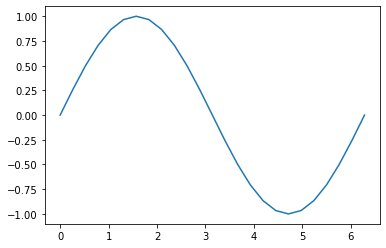

In [ ]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

Let’s have a closer look at the tensor ``b``. When we print it, we see
an indicator that it is tracking its computation history:




In [ ]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward>)


This ``grad_fn`` gives us a hint that when we execute the
backpropagation step and compute gradients, we’ll need to compute the
derivative of $sin(x)$ for all this tensor’s inputs.

Let’s perform some more computations:




In [ ]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finally, let’s compute a single-element output. When you call
``.backward()`` on a tensor with no arguments, it expects the calling
tensor to contain only a single element, as is the case when computing a
loss function.




In [ ]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Each ``grad_fn`` stored with our tensors allows you to walk the
computation all the way back to its inputs with its ``next_functions``
property. We can see below that drilling down on this property on ``d``
shows us the gradient functions for all the prior tensors. Note that
``a.grad_fn`` is reported as ``None``, indicating that this was an input
to the function with no history of its own.




In [ ]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x7f86a2786520>, 0), (None, 0))
((<SinBackward object at 0x7f86a27861f0>, 0), (None, 0))
((<AccumulateGrad object at 0x7f86a27865e0>, 0),)
()

c:

b:

a:
None


With all this machinery in place, how do we get derivatives out? You
call the ``backward()`` method on the output, and check the input’s
``grad`` property to inspect the gradients:




tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


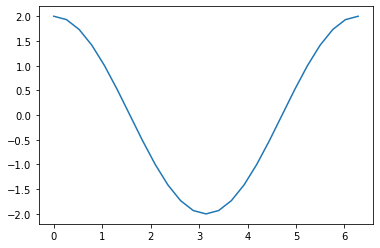

In [ ]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

Recall the computation steps we took to get here:

::

   a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
   b = torch.sin(a)
   c = 2 * b
   d = c + 1
   out = d.sum()

Adding a constant, as we did to compute ``d``, does not change the
derivative. That leaves $c = 2 * b = 2 * sin(a)$, the derivative
of which should be $2 * cos(a)$. Looking at the graph above,
that’s just what we see.

Be aware that only *leaf nodes* of the computation have their gradients
computed. If you tried, for example, ``print(c.grad)`` you’d get back
``None``. In this simple example, only the input is a leaf node, so only
it has gradients computed.

## 2. Autograd in Training

We’ve had a brief look at how autograd works, but how does it look when
it’s used for its intended purpose? Let’s define a small model and
examine how it changes after a single training batch. First, define a
few constants, our model, and some stand-ins for inputs and outputs:




In [ ]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
        
        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

One thing you might notice is that we never specify
``requires_grad=True`` for the model’s layers. Within a subclass of
``torch.nn.Module``, it’s assumed that we want to track gradients on the
layers’ weights for learning.

If we look at the layers of the model, we can examine the values of the
weights, and verify that no gradients have been computed yet:




In [ ]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([ 0.0405,  0.0517,  0.0298, -0.0291,  0.0160, -0.0314,  0.0809,  0.0138,
         0.0822,  0.0788], grad_fn=<SliceBackward>)
None


Let’s see how this changes when we run through one training batch. For a
loss function, we’ll just use the square of the Euclidean distance
between our ``prediction`` and the ``ideal_output``, and we’ll use a
basic stochastic gradient descent optimizer.




In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(178.6028, grad_fn=<SumBackward0>)


Now, let’s call ``loss.backward()`` and see what happens:




In [ ]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0405,  0.0517,  0.0298, -0.0291,  0.0160, -0.0314,  0.0809,  0.0138,
         0.0822,  0.0788], grad_fn=<SliceBackward>)
tensor([ 3.6615,  1.1695,  6.9167,  0.2765, -4.1262,  0.2296,  2.6350,  6.8546,
         8.7117,  3.2128])


We can see that the gradients have been computed for each learning
weight, but the weights remain unchanged, because we haven’t run the
optimizer yet. The optimizer is responsible for updating model weights
based on the computed gradients.




In [ ]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0368,  0.0505,  0.0229, -0.0294,  0.0202, -0.0317,  0.0783,  0.0070,
         0.0735,  0.0756], grad_fn=<SliceBackward>)
tensor([ 3.6615,  1.1695,  6.9167,  0.2765, -4.1262,  0.2296,  2.6350,  6.8546,
         8.7117,  3.2128])


You should see that ``layer2``\ ’s weights have changed.

One important thing about the process: After calling
``optimizer.step()``, you need to call ``optimizer.zero_grad()``, or
else every time you run ``loss.backward()``, the gradients on the
learning weights will accumulate:




In [ ]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()
    
print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad(set_to_none=False)

print(model.layer2.weight.grad[0][0:10])

tensor([ 3.6615,  1.1695,  6.9167,  0.2765, -4.1262,  0.2296,  2.6350,  6.8546,
         8.7117,  3.2128])
tensor([ 25.3625,  16.5202,  18.0125,   4.7924, -23.3872,   2.7822,  -2.8591,
         18.3361,  17.5841,   4.7051])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


After running the cell above, you should see that after running
``loss.backward()`` multiple times, the magnitudes of most of the
gradients will be much larger. Failing to zero the gradients before
running your next training batch will cause the gradients to blow up in
this manner, causing incorrect and unpredictable learning results.



## 3. Advanced Topic: More Autograd Detail and the High-Level API

If you have a function with an n-dimensional input and m-dimensional
output, $\vec{y}=f(\vec{x})$, the complete gradient is a matrix of
the derivative of every output with respect to every input, called the
*Jacobian:*

\begin{align}J
     =
     \left(\begin{array}{ccc}
     \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
     \vdots & \ddots & \vdots\\
     \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
     \end{array}\right)\end{align}

If you have a second function, $l=g\left(\vec{y}\right)$ that
takes m-dimensional input (that is, the same dimensionality as the
output above), and returns a scalar output, you can express its
gradients with respect to $\vec{y}$ as a column vector,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$
- which is really just a one-column Jacobian.

More concretely, imagine the first function as your PyTorch model (with
potentially many inputs and many outputs) and the second function as a
loss function (with the model’s output as input, and the loss value as
the scalar output).

If we multiply the first function’s Jacobian by the gradient of the
second function, and apply the chain rule, we get:

$$
\begin{align}
J^{T}\cdot v &= \left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right) \left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)\\
   &= \left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)
\end{align}
$$

Note: You could also use the equivalent operation $v^{T}\cdot J$,
and get back a row vector.

The resulting column vector is the *gradient of the second function with
respect to the inputs of the first* - or in the case of our model and
loss function, the gradient of the loss with respect to the model
inputs.

**``torch.autograd`` is an engine for computing these products.** This
is how we accumulate the gradients over the learning weights during the
backward pass.

For this reason, the ``backward()`` call can *also* take an optional
vector input. This vector represents a set of gradients over the tensor,
which are multiplied by the Jacobian of the autograd-traced tensor that
precedes it. Let’s try a specific example with a small vector:




In [ ]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([-614.4812,   47.1418, 1018.6722], grad_fn=<MulBackward0>)


If we tried to call ``y.backward()`` now, we’d get a runtime error and a
message that gradients can only be *implicitly* computed for scalar
outputs. For a multi-dimensional output, autograd expects us to provide
gradients for those three outputs that it can multiply into the
Jacobian:




In [ ]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # stand-in for gradients
y.backward(v)

print(x.grad)

tensor([5.1200e+01, 5.1200e+02, 5.1200e-02])


(Note that the output gradients are all related to powers of two - which
we’d expect from a repeated doubling operation.)

### The High-Level API

There is an API on autograd that gives you direct access to important
differential matrix and vector operations. In particular, it allows you
to calculate the Jacobian and the *Hessian* matrices of a particular
function for particular inputs. (The Hessian is like the Jacobian, but
expresses all partial *second* derivatives.) It also provides methods
for taking vector products with these matrices.

Let’s take the Jacobian of a simple function, evaluated for a 2
single-element inputs:




In [ ]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.2711]), tensor([0.7939]))


(tensor([[2.6229]]), tensor([[3.]]))

If you look closely, the first output should equal $2e^x$ (since
the derivative of $e^x$ is $e^x$), and the second value
should be 3.

You can, of course, do this with higher-order tensors:




In [ ]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.4968, 0.6422, 0.2565]), tensor([0.3290, 0.3193, 0.3449]))


(tensor([[3.2869, 0.0000, 0.0000],
         [0.0000, 3.8012, 0.0000],
         [0.0000, 0.0000, 2.5847]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

The ``torch.autograd.functional.hessian()`` method works identically
(assuming your function is twice differentiable), but returns a matrix
of all second derivatives.

There is also a function to directly compute the vector-Jacobian
product, if you provide the vector:




In [ ]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([ 500.6450, -980.7059, 1476.7811]),
 tensor([1.0240e+02, 1.0240e+03, 1.0240e-01]))